In [110]:
import numpy as np
import pandas as pd
import subprocess
import sys
from pygimli.meshtools import readGmsh
import pygimli as pg

from scipy.spatial import distance_matrix
from itertools import combinations


csv_file = '../data/cs_694.csv'

data = pd.read_csv(csv_file)
data = data.rename(columns={'IC':'value'})
data['y'] = np.zeros(len(data['x']), dtype=int)
data['z'] = data['z']

print(data)





       Unnamed: 0    x   z  value  y
0               0    0   0    1.0  0
1               1    0   1    1.0  0
2               2    0   2    1.0  0
3               3    0   3    1.0  0
4               4    0   4    4.0  0
...           ...  ...  ..    ... ..
16379       16379  511  27    1.0  0
16380       16380  511  28    1.0  0
16381       16381  511  29    1.0  0
16382       16382  511  30    1.0  0
16383       16383  511  31    3.0  0

[16384 rows x 5 columns]


In [111]:
nodes = data[['x','y','z']].to_numpy()

node_numbers = list(range(1, len(nodes) + 1))


def find_closest_triplets(nodes, node_numbers):
    # Compute pairwise distance matrix
    dist_matrix = distance_matrix(nodes, nodes)
    triangles = []
    
    # Iterate through each node
    for i in range(len(nodes)):
        # Get the distances from the current node to all other nodes
        distances = dist_matrix[i]
        
        # Exclude the distance to itself by setting it to a large number
        distances[i] = np.inf

        # Find the indices of the two closest nodes
        # closest_indices = np.argsort(distances)[:2]
        closest_indices = np.where(distances<=1)[0]

       
        # Form a triangle with the current node and the two closest nodes
        triangle = (node_numbers[i], node_numbers[closest_indices[0]], node_numbers[closest_indices[1]])
        for k in range(len(closest_indices)-1):
            triangle = (node_numbers[i], node_numbers[closest_indices[k]], node_numbers[closest_indices[k+1]], int(data['value'][i]))
            triangles.append((triangle))

    # Remove duplicates by converting the list of triangles to a set and back to a list
    triangles = list(set(triangles))
    
    return triangles

triangles = find_closest_triplets(nodes, node_numbers)


In [112]:
points = data[['x','y','z']].to_numpy()
val = data['value'].tolist()

# Open the .msh file
with open('../data/mesh_auto2.msh', 'w') as mshfile:
    mshfile.write("$MeshFormat\n")
    mshfile.write("2.2 0 8\n")
    mshfile.write("$EndMeshFormat\n")
    mshfile.write("$Nodes\n")
    mshfile.write(f"{len(points)}\n")
    for i, (x, y, z) in enumerate(points, 1):
        mshfile.write(f"{i} {x} {y} {z}\n")
    mshfile.write("$EndNodes\n")
    mshfile.write("$Elements\n")
    mshfile.write(f"{len(triangles)}\n")
    for i, (x, y, z, q) in enumerate(triangles, 1):
            mshfile.write(f"{i} {2} {1} {q} {x} {y} {z} \n")
    
    mshfile.write("$EndElements\n")
    

../data/mesh_auto2.msh
Mesh: Nodes: 16384 Cells: 48064 Boundaries: 64447
[1. 3. 4. 5.]


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x1645fe259d0>)

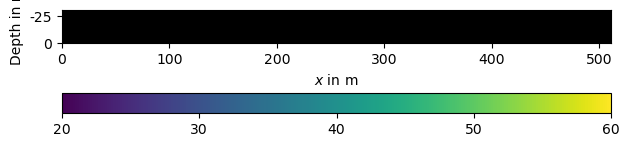

In [113]:
from pygimli.meshtools import readGmsh
import matplotlib.pyplot as plt
print("../data/mesh_auto2.msh")
mesh= readGmsh("../data/mesh_auto2.msh", verbose=False)
print(mesh)
a=[]
for i in range(1,17560):
    a = np.append(a, mesh.cells()[i].marker())

print(np.unique(a))
testi = [[1,20],[3,40],[4,50],[5,60]]
# print(np.array([node_numbers,data['value'].tolist()]))
pg.show(mesh,data=testi, showmesh=False)


In [114]:
from pygimli.physics import ert
from ertoolbox import inversion
EX = np.unique(data['x'])
EZ = np.zeros(len(EX), dtype=int)
electrodes = [[x, y] for x, y in zip(EX, EZ)]
electrodes = electrodes[1:-1]
scheme_dd = ert.createData(elecs=electrodes, schemeName='dd')
print(scheme_dd)
print(scheme_dd['k'])

simdata = ert.simulate(
         mesh=mesh, scheme=scheme_dd, res=testi
    )

inversion_dd_1 = inversion(simdata, mesh, saveresult=False)

Data: Sensors: 510 data: 128778, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']
128778 [-18.849555921538762,...,-411850243.080823]


RuntimeError: ./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == nan